# Basic data analysis tasks

- Data: Fitness in Arabidopsis recombinant inbred lines
- Data input: CSV files, missing data
- Data description: Summary statistics, plots
- Modeling: Linear regression

## Example: Fitness measured in Arabidopsis recombinant inbred lines

This is phenotype data from Ågren et. al. (2013) via John Lovell.  A set of
Arabidopsis recombinant inbred lines were derived from a cross of two
parents from Italy and Sweden.  They were grown in three years
(2009-2011) in Italy and Sweden.  The phenotype is the average number
of seeds per plant for each line which is a measure of fitness. We also
have the genotype data for the FLC (Flowering Time C) locus which is known to affect flowering time, an important trait affecting fitness in plants.

In [1]:
using Statistics, CSV, Plots, DataFrames, GLM

## Reading data

We read in data from a web URL by first downloading it into a local file,
and then parsing that file into a data frame.

Column names:

- id: ID of RI line (first two are the parents)
- it09: Italy 2009
- it10: Italy 2010
- it11: Italy 2011
- sw09: Sweden 2009
- sw10: Sweden 2010
- sw11: Sweden 2011
- flc: Flowering time locus (C) genotype


In [2]:
agrenURL = "https://raw.githubusercontent.com/sens/smalldata/master/arabidopsis/agren2013.csv"
agren = CSV.read(download(agrenURL),DataFrame,missingstring="NA")
first(agren,10)

Row,it09,it10,it11,sw09,sw10,sw11,id,flc
,Float64?,Float64?,Float64,Float64?,Float64?,Float64,Int64,Int64
1,19.7616,24.1761,15.6778,5.66443,21.4804,4.47778,1,1
2,6.28846,1.77401,3.23889,9.54305,22.1222,7.76667,2,2
3,12.034,12.4605,10.601,11.8038,23.0487,14.8712,3,2
4,20.1253,14.1169,12.9035,7.44263,22.5834,8.1937,6,1
5,15.1278,13.2925,15.0646,6.89696,22.1404,8.4891,7,1
6,19.2091,13.9549,12.9868,8.39536,25.5612,8.08018,8,1
7,12.9434,11.9672,11.4831,12.014,24.298,18.1587,11,2
8,14.2244,5.45326,5.124,8.51941,22.8739,19.51,13,1
9,20.5921,14.8691,11.1797,6.51861,21.5116,8.03754,14,1


## Data description

We get an outline of the variables in the data frame using `describe`. Note the types of each column.  Notice that the columns with missing data have a different type.  Julia has a special `missing` value and type.  Columns with missing data will be the union of the `Missing` type and the type of the rest of the data.

In [3]:
describe(agren)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,Type
1,it09,12.2106,6.28846,12.0582,20.5921,6,"Union{Missing, Float64}"
2,it10,8.08256,1.77401,7.53993,24.1761,2,"Union{Missing, Float64}"
3,it11,8.92073,3.23889,8.52447,19.3107,0,Float64
4,sw09,10.8503,5.66443,10.832,15.0012,6,"Union{Missing, Float64}"
5,sw10,23.3658,19.2318,23.0893,34.1327,2,"Union{Missing, Float64}"
6,sw11,13.4934,4.47778,12.8102,32.1889,0,Float64
7,id,325.637,1,313.5,700,0,Int64
8,flc,1.535,1,2.0,2,0,Int64


## Calculating summary statistics

To calculate summary statistics, we have to be aware of any missingness, and when we have missing data, we have to skip the missing observations using `skipmissing`. Otherwise, it will just return `missing`.

In [4]:
mean(skipmissing(agren.it09)) |> (x-> round(x,digits=3))

12.211

In [5]:
mean(agren.it09)

missing

To calculate the mean of all the columns we can do it several ways.  One option is to apply the mean function to each column.

In [6]:
mean.(skipmissing.(eachcol(agren)))

8-element Vector{Float64}:
  12.210566789309647
   8.082563855927145
   8.920732948515003
  10.850313666266498
  23.36584553505025
  13.493410758197498
 325.6375
   1.535

Another way is to use a map function over columns, as follows. This looks nicer.

In [7]:
mapcols(x -> mean(skipmissing(x)),agren)

Row,it09,it10,it11,sw09,sw10,sw11,id,flc
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,12.2106,8.08256,8.92073,10.8503,23.3658,13.4934,325.637,1.535


## Visualization: histogram

One of the preliminary steps is to visualize the data using a histogram.  Since those functions only deal with non-missing data, we have to convert the data to floating point.

In [8]:
Float64.(skipmissing(agren.it09)) |> (x->first(x,10))

10-element Vector{Float64}:
 19.7615894
  6.288461538
 12.034024
 20.12533947
 15.12775059
 19.20913213
 12.94336695
 14.224423
 20.59205843
 15.61411457

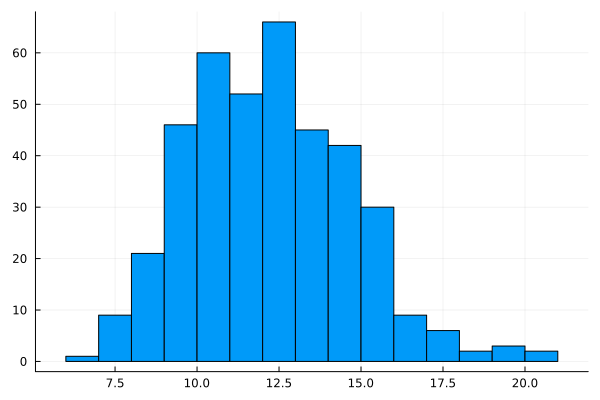

In [9]:
histogram(Float64.(skipmissing(agren.it09)),lab="")
# display.(histogram.(eachcol(agren)))

## Visualization: scatterplot

Making a scatterplot is straightforward.  We log transform the data here using the `log2` function.

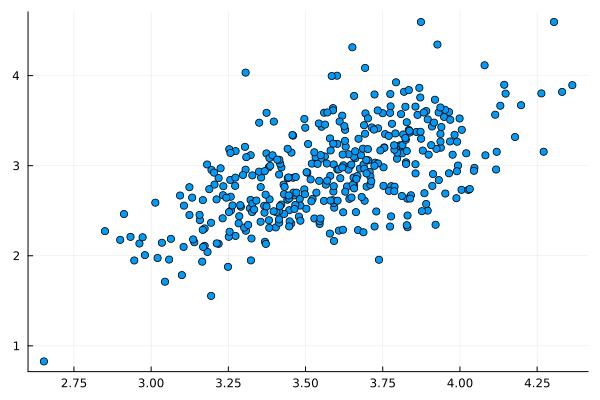

In [10]:
scatter(log2.(agren.it09),log2.(agren.it10),lab="")

## Modeling: linear regression

If we want to predict the fitness in 2011 using 2009 data, we can use linear regression.  The syntax is very similar to what you might use in R.  Notice the use of the `@formula` macro to express a formula.  This is another example of a domain-specific language.

In [11]:
out0 = lm(@formula(it11~it09+flc),agren)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

it11 ~ 1 + it09 + flc

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   1.32384    0.617786    2.14    0.0327   0.109246   2.53844
it09          0.644665   0.0408089  15.80    <1e-43   0.564433   0.724897
flc          -0.191375   0.19962    -0.96    0.3383  -0.583837   0.201088
─────────────────────────────────────────────────────────────────────────

## Extracting information

We can get the coefficients and the variance-covariance matrix of the estimates using the `coef` and `vcov` functions.

In [12]:
coef(out0)

3-element Vector{Float64}:
  1.3238442023474766
  0.6446651610115701
 -0.19137472009472786

In [13]:
vcov(out0)

3×3 Matrix{Float64}:
  0.38166    -0.0215339    -0.0708066
 -0.0215339   0.00166536    0.000779437
 -0.0708066   0.000779437   0.0398481

## Residual plots

Residual plots are using the `resid` and `predict` functions.

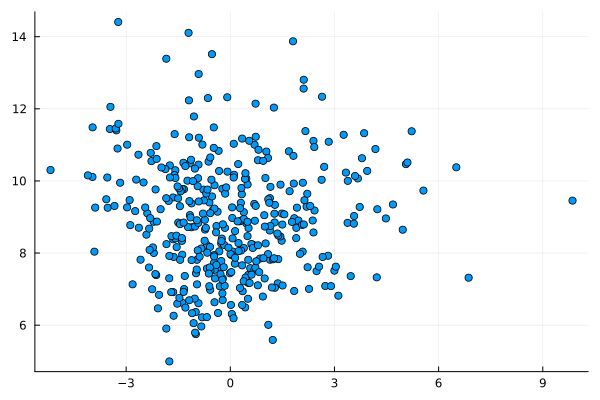

In [14]:
scatter(residuals(out0),predict(out0),lab="")

## GLM

The syntax for generalized linear models is very similar to that of linear models.  One small difference is that here the estimation is done using maximum likelihood, and the user has to specify the distribution of the outcome/response, and the link function they wish to use.  There is no quasi-likelihood option here.

In [15]:
out1 = glm(@formula( it11 ~ log(it09) ),agren,Normal(),LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

it11 ~ 1 + :(log(it09))

Coefficients:
──────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0167844   0.14326    -0.12    0.9067  -0.29757    0.264001
log(it09)     0.88134     0.0559823  15.74    <1e-55   0.771617   0.991063
──────────────────────────────────────────────────────────────────────────

## Generating random numbers

In Julia distributions are a type, so there is a uniform interface for interacting with them using multiple dispatch.  The idea is that depending on the type of distribution, a different function gets called behind the scenes. Here is how we generate random uniform or normal numbers.

In [16]:
using Random
using Distributions

In [17]:
rand(Uniform(),2,2)

2×2 Matrix{Float64}:
 0.269737   0.56462
 0.0882769  0.58333

In [18]:
rand(Normal(),2,2)

2×2 Matrix{Float64}:
 -1.33676    0.40877
  0.111623  -1.69938

For reproducibility, one might want to specify the type of pseudo random number generator and the seed.

In [19]:
# initialize random number generator
rnd = MersenneTwister(100)
# Draw uniform (0,1) numbers in 4x4 matrix
rand(rnd,Uniform(),4,4)

4×4 Matrix{Float64}:
 0.260125   0.9676    0.972755  0.557837
 0.190313   0.645691  0.868194  0.893169
 0.660911   0.545968  0.172707  0.199381
 0.0671932  0.526845  0.52399   0.0893719

## Calculating probabilities and densities

The interface for calculating othe probabilistic quantities is also uniform.

Calculating the CDF of the normal distribution

In [20]:
cdf(Normal(0,1),1.96)

0.9750021048517795

Quantiles of the normal distribution.

In [21]:
quantile(Normal(),0.95)

1.6448536269514717

Generating random normal variables with mean 0.3 and standard deviation 0.5.

In [22]:
x = rand(Normal(0.3,0.5),1000);

We now fit the MLE assuming a normal distribution.

In [23]:
normFit = fit_mle(Normal,x)

Normal{Float64}(μ=0.2913864375391153, σ=0.5021307353379704)

We generate normal variables with parameters equal to the estimated ones.

In [24]:
rand(normFit,10)

10-element Vector{Float64}:
  0.14535895774249635
  0.14147730392040908
 -0.7133458223299751
  0.03838521988178704
 -0.2447610824860888
  1.0886282344882898
  0.6180851039635277
  0.1933881528782382
  0.40499703242631024
  0.7402528154043158

We will see more of this in the Bayesian data analysis lecture.

## Data wrangling tasks

The DataFrames package has utilities for manipulating data frames.  As an example, we load a dataset for English Premier League results data.

In [25]:
eplURL = "https://raw.githubusercontent.com/sens/smalldata/master/soccer/E0.csv"
epl = CSV.read(download(eplURL),DataFrame);

In [26]:
first(epl)

Row,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
,String3,String15,String15,String15,Int64,Int64,String1,Int64,Int64,String1,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,E0,08/08/15,Bournemouth,Aston Villa,0,1,A,0,0,D,M Clattenburg,11,7,2,3,13,13,6,3,3,4,0,0,2.0,3.6,4.0,2.0,3.3,3.7,2.1,3.3,3.3,2.05,3.3,4.0,1.95,3.65,4.27,1.91,3.5,4.0,2.0,3.5,4.2,45,2.1,1.96,3.65,3.48,4.33,3.98,43,2.11,2.02,1.88,1.79,26,-0.5,1.98,1.93,1.99,1.92,1.82,3.88,4.7


In [27]:
names(epl)

65-element Vector{String}:
 "Div"
 "Date"
 "HomeTeam"
 "AwayTeam"
 "FTHG"
 "FTAG"
 "FTR"
 "HTHG"
 "HTAG"
 "HTR"
 "Referee"
 "HS"
 "AS"
 ⋮
 "BbAv>2.5"
 "BbMx<2.5"
 "BbAv<2.5"
 "BbAH"
 "BbAHh"
 "BbMxAHH"
 "BbAvAHH"
 "BbMxAHA"
 "BbAvAHA"
 "PSCH"
 "PSCD"
 "PSCA"

We create a narrower version by selecting necessary columns using regular expressions.

In [28]:
( eplNarrow = select(epl,r"Date|Team|HT|FT") )  |> (x->first(x,10))

Row,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
,String15,String15,String15,Int64,Int64,String1,Int64,Int64,String1
1,08/08/15,Bournemouth,Aston Villa,0,1,A,0,0,D
2,08/08/15,Chelsea,Swansea,2,2,D,2,1,H
3,08/08/15,Everton,Watford,2,2,D,0,1,A
4,08/08/15,Leicester,Sunderland,4,2,H,3,0,H
5,08/08/15,Man United,Tottenham,1,0,H,1,0,H
6,08/08/15,Norwich,Crystal Palace,1,3,A,0,1,A
7,09/08/15,Arsenal,West Ham,0,2,A,0,1,A
8,09/08/15,Newcastle,Southampton,2,2,D,1,1,D
9,09/08/15,Stoke,Liverpool,0,1,A,0,0,D


If we want to subset the data to only Arsenal home games, we use the `subset` function. Notice how the selectin function works in terms of the name of the column and the (anonymous) function used to generate true/false conditions.

In [29]:
subset(eplNarrow,:HomeTeam => (x->x.=="Arsenal"), :FTAG => (x->x.>0))

Row,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
,String15,String15,String15,Int64,Int64,String1,Int64,Int64,String1
1,09/08/15,Arsenal,West Ham,0,2,A,0,1,A
2,24/10/15,Arsenal,Everton,2,1,H,2,1,H
3,08/11/15,Arsenal,Tottenham,1,1,D,0,1,A
4,05/12/15,Arsenal,Sunderland,3,1,H,1,1,D
5,21/12/15,Arsenal,Man City,2,1,H,2,0,H
6,24/01/16,Arsenal,Chelsea,0,1,A,0,1,A
7,14/02/16,Arsenal,Leicester,2,1,H,0,1,A
8,02/03/16,Arsenal,Swansea,1,2,A,1,1,D
9,17/04/16,Arsenal,Crystal Palace,1,1,D,1,0,H


In [30]:
subset(eplNarrow,[:HomeTeam,:FTAG] => (x,y)-> (x.=="Arsenal").& (y.>0) )

Row,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
,String15,String15,String15,Int64,Int64,String1,Int64,Int64,String1
1,09/08/15,Arsenal,West Ham,0,2,A,0,1,A
2,24/10/15,Arsenal,Everton,2,1,H,2,1,H
3,08/11/15,Arsenal,Tottenham,1,1,D,0,1,A
4,05/12/15,Arsenal,Sunderland,3,1,H,1,1,D
5,21/12/15,Arsenal,Man City,2,1,H,2,0,H
6,24/01/16,Arsenal,Chelsea,0,1,A,0,1,A
7,14/02/16,Arsenal,Leicester,2,1,H,0,1,A
8,02/03/16,Arsenal,Swansea,1,2,A,1,1,D
9,17/04/16,Arsenal,Crystal Palace,1,1,D,1,0,H


The `combine` function can be used for summarization.  Now, we use a similar "dictionary" approach where we name the column to operate on, the function being applied, and the name of the new column for the result.

In [31]:
combine( groupby(eplNarrow,:HomeTeam), :FTHG => sum => :TotalHomeGoals )

Row,HomeTeam,TotalHomeGoals
,String15,Int64
1,Bournemouth,23
2,Chelsea,32
3,Everton,35
4,Leicester,35
5,Man United,27
6,Norwich,26
7,Arsenal,31
8,Newcastle,32
9,Stoke,22


Below is a more complex example, where we calculate the number of points earned by each team by first writing a function to calculate the number of points earned by a home team.  We calculate points at home, and away.  Then we add them and sort them.

In [32]:
homepoints(hg,ag) = 
begin 
    if(hg>ag) return 3
    elseif (hg==ag) return 1
    else return 0
    end
end

homepoints (generic function with 1 method)

In [33]:
hp = combine( groupby(eplNarrow,:HomeTeam), [:FTHG,:FTAG] => ( (x,y) -> sum(homepoints.(x,y)) ) => :HomePoints  )
ap = combine( groupby(eplNarrow,:AwayTeam), [:FTHG,:FTAG] => ( (x,y) -> sum(homepoints.(y,x)) ) => :AwayPoints  );

In [34]:
hcat(sort(ap,:AwayTeam),sort(hp,:HomeTeam))

Row,AwayTeam,AwayPoints,HomeTeam,HomePoints
,String15,Int64,String15,Int64
1,Arsenal,31,Arsenal,40
2,Aston Villa,6,Aston Villa,11
3,Bournemouth,22,Bournemouth,20
4,Chelsea,26,Chelsea,24
5,Crystal Palace,21,Crystal Palace,21
6,Everton,24,Everton,23
7,Leicester,39,Leicester,42
8,Liverpool,28,Liverpool,32
9,Man City,28,Man City,38


## Exercises

- Arabidopsis: Predit fitness in Sweden in 2011 using fitness in Italy in 2011 and FLC locus.
- EPL: Sort teams by total goals scored at home